# Install of required package

This block only needs to be executed one to install the required packages in your python env.

In [1]:
# import sys
# !{sys.executable} -m pip uninstall smi-analysis --yes
# !{sys.executable} -m pip install git+https://github.com/gfreychet/smi-analysis.git
# !{sys.executable} -m pip uninstall saxs-nxformat --yes
# !{sys.executable} -m pip install git+https://github.com/CEA-MetroCarac/saxs_nxformat.git


In [2]:
%matplotlib ipympl

import inspect
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import re

from pathlib import Path
from colorama import Fore, Style
from saxs_nxformat.class_nexus_file import NexusFile
from smi_analysis import SMI_beamline

  File "C:\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Python310\envs\env_nxformat\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Python310\envs\env_nxformat\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Python310\envs\env_nxformat\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "C:\Python310\envs\env_nxformat\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "C:\Python310\lib\asyncio\base_events.py", line 595, in run_forever
    self._run_once()
  File "C:\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
    handle._run()
  File "C:\Python310\lib\asyncio\events.py", line 80, in _run
    self._c

# Method list

This function will display the available methods in the NexusFile class as well as their parameters and default values

In [3]:
def show_method():    
    for name, method in inspect.getmembers(NexusFile, predicate=inspect.isfunction):
        print(f"\n{name}")
        print(f"Docstring : {method.__doc__}")
        signature = inspect.signature(method)
        param_list = list(signature.parameters.items())
        for param in param_list:
            if param[0] != "self":
                param_str = str(param[1])
                print(f"    {param_str}")

In [4]:
show_method()


__init__
Docstring : 
        The init of this class consists of extracting every releavant parameters
        from the h5 file and using it to open the data and stitch it using the SMI_package

        Parameters
        ----------
        h5_paths
            The path of the h5 files we want to open passed as a list of strings

        do_batch :
            Determines wether the data is assembled in a new file or not and whether it is
            displayed a single figure or not
        
    h5_paths
    do_batch=False

_display_data
Docstring : 
        Displays the data contained in the DATA_... group

        Parameters
        ----------
        nxfile :
            File object

        index :
            Index of the file

        optimize_range :
            Bool to know if the range should be optimized for display

        extracted_param_data :
            Data on which extracted_value_data depends

        extracted_value_data :
            The value we want to display (I

# Inspecting your h5 file

This function can be used to visualize the structure of the HDF5 file.
There are three types of element :

    - Groups (red) : you can view them as a directory, it can contain other groups, dataset or attributes
    - Datasets (blue) : you can view them as a file, it can only contain attributes
    - Attributes (green) : you can view them as metadata, it cannot contain anything and gives additional information
    
You just have to pass the path of your data file in. Additionally you can choose wether you want to see what's in groups and what's inside datasets

In [5]:
def explore_file(group, explore_group=False, explore_dataset=False, level=0):
    indent = "|  " * level
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            print(f"{indent}{Fore.RED}Group : {key}{Style.RESET_ALL}")
            explore_file(item, explore_group, explore_dataset, level + 1)
        elif isinstance(item, h5py.Dataset) and explore_group:
            print(f"{indent}{Fore.CYAN}Dataset : {key}{Style.RESET_ALL}")
            if item.attrs and explore_dataset:
                print(f"{indent}  {Fore.GREEN}Attributes : {key}{Style.RESET_ALL}")
                for key_attribute, item_attribute in item.attrs.items():
                    print(f"{indent}    - {key_attribute} : {item_attribute}")

# Specify the directory containing your data files

Change the variable **data_dir** to the path of the directory containing your data. The data needs to have the HDF5 format with the NeXus standard to work properly.

In [6]:
data_dir = r"C:\Users\AT280565\Desktop\Data Treatment Center\Treated Data\instrument - Xeuss\year - 2025\config ID - 2024-12-19T15-00\experiment - measure\detector - SWAXS"

path_list = []

for file in os.listdir(data_dir):
    print(file)
    path_list.append(os.path.join(data_dir, file))

Glassy_Carbon_img00001_20250306143231.h5
Glassy_Carbon_img00001_20250306143313.h5
Glassy_Carbon_img00004_20250306143223.h5
Glassy_Carbon_img00004_20250306143258.h5
Glassy_Carbon_img00005_20250306143250.h5
Glassy_Carbon_img00008_20250306143234.h5


# Processing using the NexusFile class

## Open your files
To open your file, you need to use the NexusFile class, pass a list of the paths of all the data you want to treat. You can use the *do_batch* option to either treat your file one after the other (do_batch=False) or altogether (do_batch=True).

**Be carefull** : When you open files, you need to use the nexus_close() method in the same block to close the files properly 

In [7]:
nx_files = NexusFile(path_list, do_batch=True)
nx_files.nexus_close()

## Viewing what's inside the HDF5 file

Now is the time to check what is in the .h5 file using the function explore_file defined earlier

In [8]:
explore_file(h5py.File(path_list[0]), False, False)

Group : ENTRY
|  Group : DATA
|  Group : DATA_Q_SPACE
|  Group : DATA_RAD_AVG
|  Group : INSTRUMENT
|  |  Group : APERTURE
|  |  Group : COLLIMATOR
|  |  Group : DETECTOR
|  |  Group : SOURCE
|  Group : PROCESS_Q_SPACE
|  Group : PROCESS_RAD_AVG
|  Group : SAMPLE


## Basic processes

Nativelly, raw data should be inside a group called DATA, which is itself in a group called ENTRY

If you have raw data you can convert them in q-space using the method process_q_space().
process_q_space uses 4 parameters (you can get more information by using the show_method function) Just know that if you use an existing group_name while saving, the old data will be replaced by the new data you just generated.

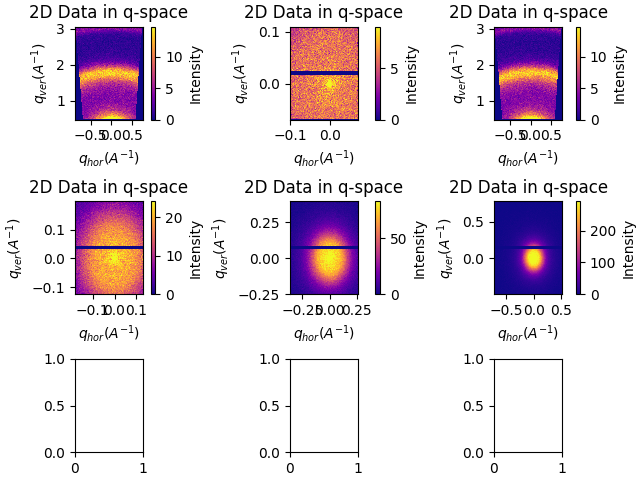

In [9]:
nx_files = NexusFile(path_list, do_batch=True)
nx_files.process_q_space(display=True, save=False, group_name="DATA_Q_SPACE", percentile=99)
nx_files.nexus_close()

## Reduction of data

You can go further and reduce your data via integration, let's use process_radial_averaging as an example

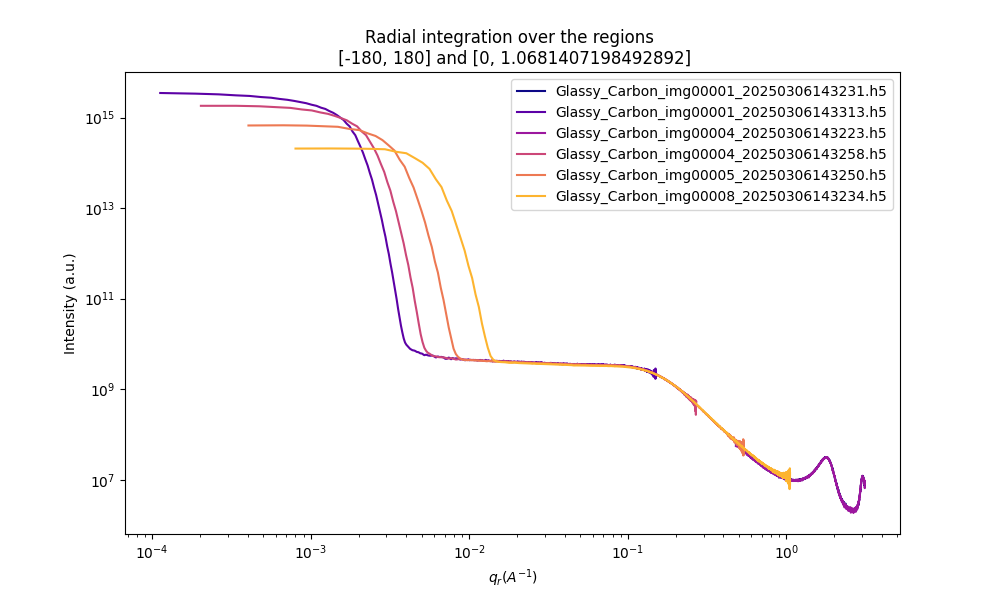

In [10]:
nx_files = NexusFile(path_list, do_batch=True)
nx_files.process_radial_average(display=True, save=False, group_name="DATA_RAD_AVG")
nx_files.nexus_close()

# Processing using the raw functions

Under this title is another way to process your data and putting your hand in the code directly, bypassing the NexusFile class.

Below are all the process methods in present in the NexusFile class. Thes function only work for one file at a time so you may have to put them in a for loop for batch processing.

This is basically what happens in NexusFile

## HDF5 utils functions

Just a bunch of functions used to managed HDF5 files with the NeXus Standard

In [11]:
def repack_hdf5(input_file, output_file):
    """
    Repack an HDF5 file to reduce its size by copying its content to a new file.

    Parameters
    ----------
    input_file : str
        Path to the input HDF5 file.
    output_file : str
        Path to the output (repacked) HDF5 file.
    """
    with h5py.File(input_file, 'r') as src, h5py.File(output_file, 'w') as dest:
        src.copy("/ENTRY", dest)
    os.remove(input_file)
    shutil.move(output_file, input_file)


def create_process(hdf5_file, group_h5path, process_name, process_desc):
    """
    Function used to create a new group in the hdf5 file that will contain pertinent information
    concerning the process that was applied.

    Parameters
    ----------
    hdf5_file :
        File where the process is to be saved

    group_h5path :
        Path of the process group, this will define the group's name.
        For clarity this should be PROCESS_... the ellipsis corresponding
        to the name of the associated DATA_... group

    process_name :
        Name of the process

    process_desc :
        Description of the process
    """
    # We first delete the old process if it exists
    if hdf5_file.get(group_h5path):
        del hdf5_file[group_h5path]

    # We then create the group and set its attributes and datasets
    group = hdf5_file.create_group(group_h5path)
    group.attrs["canSAS_class"] = "SASprocess"

    group.create_dataset("name", data=process_name)
    group.create_dataset("description", data=process_desc)


def extract_from_h5(nx_file, h5path, data_type="dataset", attribute_name=None):
    """
    Method used to extract a dataset or attribute from the .h5 file

    Parameters
    ----------
    nx_file :
        file object

    h5path :
        h5 path of the dataset

    data_type :
        type of the value extracted (attribute or dataset)

    attribute_name :
        if it's an attribute, give its name

    Returns
    -------
    Either the attribute or dataset selected

    """
    # We get the dataset and its attributes
    dataset = nx_file[h5path]
    attributes = dataset.attrs

    # We detect if the dataset is a scalar, an array or an attribute
    if data_type == "dataset" and np.shape(dataset) == ():
        return dataset[()]
    elif data_type == "dataset" and np.shape(dataset) != ():
        return dataset[:]
    elif data_type == "attribute" and attribute_name in attributes.keys():
        return attributes[attribute_name]
    else:
        print(f"error while extracting from {h5path}")
        return None


def save_data(nx_file, parameter_symbol, parameter, dataset_name, dataset, mask):
    """
    Method used to save a dataset in the h5 file

    Parameters
    ----------
    mask :
        mask used for data treatment

    nx_file :
        file object

    parameter_symbol :
        Symbol of the parameter. will be the name of its dataset

    parameter :
        Contains the parameter data

    dataset_name :
        Name of the group containing all the data

    dataset :
        Contains the data
    """
    # We create the dataset h5path and if it exists we delete what was previously there
    dataset_name = dataset_name.upper()
    dataset_path = f"/ENTRY/{dataset_name}"
    if dataset_path in nx_file:
        del nx_file[dataset_path]

    # we copy the raw data and set the copied data to the name selected
    # That way we also copy the attributes
    nx_file.copy("ENTRY/DATA", nx_file["/ENTRY"], dataset_name)

    # we replace the raw data with the new data
    replace_h5_dataset(nx_file, f"{dataset_path}/R",
                       parameter, f"{dataset_path}/{parameter_symbol}")
    replace_h5_dataset(nx_file, f"{dataset_path}/I",
                       dataset)

    replace_h5_dataset(nx_file, f"{dataset_path}/mask",
                       mask)


def delete_data(nx_file, group_name):
    """
    Method used to properly delete data from the h5 file

    Parameters
    ----------
    nx_file :
        file object

    group_name :
        Name of the data group to delete
    """
    group_name = group_name.upper()
    if group_name in nx_file["/ENTRY"]:
        del nx_file[f"/ENTRY/{group_name}"]
    else:
        print("This group does not exists")
        
def detect_variation(array, variation_threshold):
    """
    return the indices where we go from a value under low to a value aboce high

    Parameters
    ----------
    array :
        The array where the variation have to be detected

    low :
        low threshold

    high :
        high threshold

    Returns
    -------
    list of indices where the variations are detected
    """
    diff_array = np.diff(array)
    return np.where(diff_array > variation_threshold)[0] + 1

## constructor function

This is an equivalent to \_\_init\_\_ in NexusFile
You do not need to use this function

In [12]:
def constructor(h5_path):
    """
    """
    nx_file = h5py.File(h5_path, "r+")

    dict_parameters = {
        "beam stop": [[0, 0]]
    }

    # We extract the relevant info from the H5 file
    intensity_data = [nx_file["ENTRY/DATA/I"][:]]
    position_data = [nx_file["ENTRY/DATA/R"][:]]
    dict_parameters["I raw data"] = intensity_data
    dict_parameters["R raw data"] = position_data

    # Concerning the source
    wavelength = extract_from_h5(nx_file, "ENTRY/INSTRUMENT/SOURCE/incident_wavelength")
    dict_parameters["wavelength"] = wavelength * 1e-9

    # Concerning the sample
    incident_angle = extract_from_h5(nx_file, "ENTRY/SAMPLE/yaw")
    dict_parameters["incident angle"] = incident_angle

    # Concerning the detector
    # We use a regex that detects the keyword required in the detector's name
    detector_name = extract_from_h5(nx_file, "/ENTRY/INSTRUMENT/DETECTOR/name").decode("utf-8")
    if re.search(
            "(?i)(?=.*dectris)" +
            "(?i)(?=.*eiger2)" +
            "(?i)(?=.*1m)",
            detector_name.lower()
    ):
        dict_parameters["detector name"] = "Eiger1M_xeuss"
    if re.search(
            "(?i)(?=.*" + "dectris" + ")" +
            "(?i)(?=.*" + "eiger2" + ")" +
            "(?i)(?=.*" + "500k" + ")",
            detector_name.lower()
    ):
        dict_parameters["detector name"] = "Eiger500k_xeuss"

    # Concerning the beam center
    beam_center_x = extract_from_h5(nx_file, "ENTRY/INSTRUMENT/DETECTOR/beam_center_x")
    beam_center_y = extract_from_h5(nx_file, "ENTRY/INSTRUMENT/DETECTOR/beam_center_y")
    dict_parameters["beam center"] = [beam_center_x, beam_center_y]

    # Concerning the rotations of the detector
    rotation_1 = - extract_from_h5(nx_file, "ENTRY/INSTRUMENT/DETECTOR/yaw")
    rotation_2 = extract_from_h5(nx_file, "ENTRY/INSTRUMENT/DETECTOR/pitch")
    rotation_3 = - extract_from_h5(nx_file, "ENTRY/INSTRUMENT/DETECTOR/roll")
    dict_parameters["detector rotation"] = [[rotation_1, rotation_2, rotation_3]]

    # Concerning the sample-detector distance
    sample_detector_distance = extract_from_h5(nx_file, "ENTRY/INSTRUMENT/DETECTOR/SDD")
    dict_parameters["distance"] = sample_detector_distance * 1e3

    # We input the info in the SMI package
    smi_data = SMI_beamline.SMI_geometry(
        geometry="Transmission",
        sdd=dict_parameters["distance"],
        wav=dict_parameters["wavelength"],
        alphai=dict_parameters["incident angle"],
        center=dict_parameters["beam center"],
        bs_pos=dict_parameters["beam stop"],
        detector=dict_parameters["detector name"],
        det_angles=dict_parameters["detector rotation"]
    )
    smi_data.open_data_db(dict_parameters["I raw data"])
    smi_data.stitching_data()

    return nx_file, smi_data, dict_parameters

## Display

This is the function used to display data

In [13]:
def display_function(
        nxfile=None,
        group_name=None,
        extracted_param_data=None, extracted_value_data=None,
        scale_x="log", scale_y="log",
        label_x="", label_y="", title="",
        percentile=99, optimize_range=False
):
    """
    Displays the data contained in the DATA_... group
    TODO : manage extent on 2D plot

    Parameters
    ----------
    nxfile :
        File object

    optimize_range :
        Bool to know if the range should be optimized for display

    extracted_param_data :
        Data on which extracted_value_data depends

    extracted_value_data :
        The value we want to display (Intensity mostly)

    percentile :
        Controls the intensity range. It will go from 0 to percentile / 100 * (max intensity)

    title :
        Title of the plot

    label_y :
        Title of the y axis

    label_x :
        Title of the x axis

    scale_y :
        Scale of the y axis "linear" or "log"

    scale_x :
        Scale of the x axis "linear" or "log"

    group_name:
        Name of the data group to be displayed
    """
    # We extract the intensity
    param_not_inserted = extracted_param_data is None
    value_not_inserted = extracted_param_data is None

    group_name_inserted = group_name is not None

    # We extract the data
    if value_not_inserted and group_name_inserted:
        if f"ENTRY/{group_name}" in nxfile:
            extracted_value_data = extract_from_h5(nxfile, f"ENTRY/{group_name}/I")

    # We extract the parameter
    if param_not_inserted and group_name_inserted:
        if f"ENTRY/{group_name}/R" in nxfile:
            extracted_param_data = extract_from_h5(nxfile, f"ENTRY/{group_name}/R")
        elif f"ENTRY/{group_name}/Q" in nxfile:
            extracted_param_data = extract_from_h5(nxfile, f"ENTRY/{group_name}/Q")
        elif f"ENTRY/{group_name}/Chi" in nxfile:
            extracted_param_data = extract_from_h5(nxfile, f"ENTRY/{group_name}/Chi")
        else:
            extracted_param_data = None

    # If the intensity value is a scalar we print it
    if np.isscalar(extracted_value_data):
        print(extracted_value_data)

    # If the intensity value is a 1D array we plot it
    elif len(np.shape(extracted_value_data)) == 1:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_xscale(scale_x)
        ax.set_yscale(scale_y)

        ax.set_xlabel(label_x)
        ax.set_ylabel(label_y)
        ax.set_title(title)

        if optimize_range:
            indices_high_var = detect_variation(extracted_value_data, 1e5)
            first_index, last_index = indices_high_var[0], indices_high_var[-1]
            ax.plot(
                extracted_param_data[first_index:last_index],
                extracted_value_data[first_index:last_index]
            )
        else:
            ax.plot(
                extracted_param_data,
                extracted_value_data
            )
            
        plt.show()

    # If the intensity value is a 2D array we imshow it
    elif len(np.shape(extracted_value_data)) == 2:
        fig, ax = plt.subplots(layout="constrained")
        current_ax = ax

        current_ax.set_xlabel(label_x)
        current_ax.set_ylabel(label_y)
        current_ax.set_title(title)

        cplot = current_ax.imshow(
            extracted_value_data,
            vmin=0,
            vmax=np.percentile(
                extracted_value_data[~np.isnan(extracted_value_data)],
                percentile),
            cmap="magma"
        )
        cbar = plt.colorbar(cplot, ax=current_ax)
        cbar.set_label("Intensity")
        
        plt.show()

## Processes
each function correspond sto a particular process

In [14]:
def process_q_space(
    nx_file_path, display=False, 
    save=False, 
    group_name="DATA_Q_SPACE", 
    percentile=99
):
    """
    Method used to put the data in Q space (Fourier space). This will save an array
    containing the intensity values and another array containing the vector Q associated
    to each intensities

    Parameters
    ----------
    percentile :
        Controls the intensity range. It will go from 0 to percentile / 100 * (max intensity)

    display :
        Choose if you want the result displayed or not

    save :
        Choose if you want the result saved in the .h5 or not

    group_name:
        Name of the group that will contain the data
    """
    nx_file, smi_data, dict_parameters = constructor(nx_file_path)
    smi_data.masks = [extract_from_h5(nx_file, "/ENTRY/DATA/mask")]
    smi_data.calculate_integrator_trans(dict_parameters["detector rotation"])

    if display:
        display_function(
            nx_file,
            extracted_value_data=smi_data.img_st,
            label_x="$q_{hor} (A^{-1})$",
            label_y="$q_{ver} (A^{-1})$",
            title=f"2D Data in q-space",
            percentile=percentile
        )

    # Saving the data and the process it just went trough
    if save:
        dim = np.shape(dict_parameters["R raw data"][0])
        qx_list = np.linspace(smi_data.qp[0], smi_data.qp[-1], dim[1])
        qy_list = np.linspace(smi_data.qz[-1], smi_data.qz[0], dim[0])
        qx_grid, qy_grid = np.meshgrid(qx_list, qy_list)
        mesh_q = np.stack((qx_grid, qy_grid), axis=-1)
        mask = smi_data.masks

        save_data(nx_file, "Q", mesh_q, group_name, smi_data.img_st, mask)

        create_process(nx_file,
                       f"/ENTRY/PROCESS_{group_name.removeprefix('DATA_')}",
                       "Conversion to q-space",
                       "This process converts the 2D array Q containing the position in A into a 2D "
                       "array containing the positions in q-space, A^-1. "
                       "Each element of the array Q is a vector containing qx and qy"
                       )
        
    nx_file.close()

In [15]:
def process_caking(
        nx_file_path, display=False, save=False, group_name="DATA_CAKED",
        azi_min=None, azi_max=None, pts_azi=None,
        radial_min=None, radial_max=None, pts_rad=None,
        percentile=99
):
    """
    Method used to cake the data. This will display the data in the (q_r, chi) coordinate system.

    Parameters
    ----------
    percentile :
        Controls the intensity range. It will go from 0 to percentile / 100 * (max intensity)

    display :
        Choose if you want the result displayed or not

    save :
        Choose if you want the result saved in the .h5 or not

    group_name:
        Name of the group that will contain the data

    pts_rad:
        Number of point in the radial range

    radial_max:
        Maximum of the radial range

    radial_min:
        Minimum of the radial range

    pts_azi:
        Number of point in the azimuthal range

    azi_max:
        Maximum of the azimuthal angle range

    azi_min:
        Minimum of the azimuthal angle range
    """
    nx_file, smi_data, dict_parameters = constructor(nx_file_path)

    initial_none_flags = {
        "azi_min": azi_min is None,
        "azi_max": azi_max is None,
        "radial_min": radial_min is None,
        "radial_max": radial_max is None,
        "pts_azi": pts_azi is None,
        "pts_rad": pts_rad is None,
    }

    defaults = {
        "azi_min": -180,
        "azi_max": 180,
        "radial_min": min(smi_data.qz),
        "radial_max": max(smi_data.qz),
        "pts_azi": 1000,
        "pts_rad": 1000,
    }

    # Set default values if parameters are None

    if initial_none_flags["azi_min"]:
        azi_min = defaults["azi_min"]
    if initial_none_flags["azi_max"]:
        azi_max = defaults["azi_max"]
    if initial_none_flags["radial_min"]:
        radial_min = defaults["radial_min"]
    if initial_none_flags["radial_max"]:
        radial_max = defaults["radial_max"]
    if initial_none_flags["pts_azi"]:
        pts_azi = defaults["pts_azi"]
    if initial_none_flags["pts_rad"]:
        pts_rad = defaults["pts_rad"]

    smi_data.caking(
        azimuth_range=[azi_min, azi_max],
        radial_range=[radial_min, radial_max],
        npt_azim=pts_azi,
        npt_rad=pts_rad
    )

    if display:
        display_function(
            nx_file,
            extracted_value_data=smi_data.cake,
            scale_x="log", scale_y="log",
            label_x="$q_r (A^{-1})$",
            label_y="$\\chi$",
            title=f"Caked q-space data",
            percentile=percentile
        )

    if save:
        q_list = smi_data.q_cake
        chi_list = smi_data.chi_cake
        q_grid, chi_grid = np.meshgrid(q_list, chi_list)
        mesh_cake = np.stack((q_grid, chi_grid), axis=-1)
        mask = smi_data.masks

        save_data(nx_file, "Q", mesh_cake, group_name, smi_data.cake, mask)

        create_process(nx_file,
                       f"/ENTRY/PROCESS_{group_name.removeprefix('DATA_')}",
                       "Data caking",
                       "This process plots the intensity with respect to the azimuthal angle and the distance "
                       "from"
                       "the center of the q-space. That way the rings are flattened."
                       )
    nx_file.close()

In [16]:
def process_radial_average(
        nx_file_path, display=False, save=False, group_name="DATA_RAD_AVG",
        r_min=None, r_max=None,
        angle_min=None, angle_max=None,
        pts=None
):
    """
    Method used to perform radial averaging of data in Fourier space. This will reduce the signal to
    one dimension : intensity versus distance from the center

    Parameters
    ----------
    display : bool, optional
        Choose if you want the result displayed or not.

    save : bool, optional
        Choose if you want the result saved in the .h5 or not.

    group_name : str, optional
        Name of the group that will contain the data.

    r_min : float, optional
        Minimum radial value for averaging.

    r_max : float, optional
        Maximum radial value for averaging.

    angle_min : float, optional
        Minimum angle for averaging.

    angle_max : float, optional
        Maximum angle for averaging.

    pts : int, optional
        Number of points for the averaging process.
    """
    nx_file, smi_data, dict_parameters = constructor(nx_file_path)
    
    if r_min is None:
        optimize_range = True
    else:
        optimize_range = False

    initial_none_flags = {
        "r_min": r_min is None,
        "r_max": r_max is None,
        "angle_min": angle_min is None,
        "angle_max": angle_max is None,
        "pts": pts is None,
    }

    smi_data.masks = [extract_from_h5(nx_file, "/ENTRY/DATA/mask")]
    smi_data.calculate_integrator_trans(dict_parameters["detector rotation"])
    defaults = {
        "r_max": np.sqrt(max(np.abs(smi_data.qp)) ** 2 + max(np.abs(smi_data.qz)) ** 2),
        "r_min": 0,
        "angle_min": -180,
        "angle_max": 180,
        "pts": 2000
    }

    if initial_none_flags["r_min"]:
        r_min = defaults["r_min"]
    if initial_none_flags["r_max"]:
        r_max = defaults["r_max"]
    if initial_none_flags["angle_min"]:
        angle_min = defaults["angle_min"]
    if initial_none_flags["angle_max"]:
        angle_max = defaults["angle_max"]
    if initial_none_flags["pts"]:
        pts = defaults["pts"]

    smi_data.radial_averaging(
        azimuth_range=[angle_min, angle_max],
        npt=pts,
        radial_range=[r_min, r_max]
    )

    if display:
        display_function(
            nx_file,
            extracted_param_data=smi_data.q_rad, extracted_value_data=smi_data.I_rad,
            scale_x="log", scale_y="log",
            label_x="$q_r (A^{-1})$",
            label_y="Intensity (a.u.)",
            title=f"Radial integration over the regions \n "
                  f"[{angle_min}, {angle_max}] and [{r_min}, {r_max}]",
            optimize_range=optimize_range
        )

    if save:
        q_list = smi_data.q_rad
        i_list = smi_data.I_rad
        mask = smi_data.masks
        save_data(nx_file, "Q", q_list, group_name, i_list, mask)

        create_process(nx_file,
                       f"/ENTRY/PROCESS_{group_name.removeprefix('DATA_')}",
                       "Radial averaging",
                       "This process integrates the intensity signal over a specified radial angle range"
                       " and q range, effectively rendering the signal 1D instead of 2D"
                       )
    nx_file.close()

In [26]:
def process_azimuthal_average(
        nx_file_path, display=False, save=False, group_name="DATA_AZI_AVG",
        r_min=None, r_max=None,
        angle_min=None, angle_max=None,
):
    """
    Method used to do the radial average of the data in fourier space

    Parameters
    ----------
    angle_max :
        Maximum azimuthal angle

    angle_min :
        Minimum azimuthal angle

    r_max :
        Maximum distance from the center

    r_min :
        Minimum distance from the center

    display :
        Choose if you want the result displayed or not

    save :
        Choose if you want the result saved in the .h5 or not

    group_name:
        Name of the group that will contain the data
    """

    nx_file, smi_data, dict_parameters = constructor(nx_file_path)

    initial_none_flags = {
        "r_min": r_min is None,
        "r_max": r_max is None,
        "angle_min": angle_min is None,
        "angle_max": angle_max is None,
    }

    smi_data.masks = [extract_from_h5(nx_file, "/ENTRY/DATA/mask")]
    smi_data.calculate_integrator_trans(dict_parameters["detector rotation"])

    defaults = {
        "r_max": np.sqrt(max(np.abs(smi_data.qp)) ** 2 + max(np.abs(smi_data.qz)) ** 2),
        "r_min": 0,
        "angle_min": -180,
        "angle_max": 180,
    }

    if initial_none_flags["r_min"]:
        r_min = defaults["r_min"]
    if initial_none_flags["r_max"]:
        r_max = defaults["r_max"]
    if initial_none_flags["angle_min"]:
        angle_min = defaults["angle_min"]
    if initial_none_flags["angle_max"]:
        angle_max = defaults["angle_max"]

    smi_data.azimuthal_averaging(
        azimuth_range=[angle_min, angle_max],
        radial_range=[r_min, r_max]
    )

    if display:
        display_function(
            nx_file,
            extracted_param_data=smi_data.chi_azi, extracted_value_data=smi_data.I_azi,
            scale_x="log", scale_y="log",
            label_x="$\\chi (rad)$",
            label_y="Intensity (a.u.)",
            title=f"Azimuthal integration over the regions \n "
                  f"[{angle_min}, {angle_max}] and [{r_min}, {r_max}]"
        )

    if save:
        chi_list = smi_data.chi_azi
        i_list = smi_data.I_azi
        mask = smi_data.masks
        save_data(nx_file, "Chi", chi_list, group_name, i_list, mask)
        create_process(nx_file,
                       f"/ENTRY/PROCESS_{group_name.removeprefix('DATA_')}",
                       "Azimuthal averaging",
                       "This process integrates the intensity signal over a specified azimuthal angle range"
                       " and q range, effectively rendering the signal 1D instead of 2D"
                       )
    nx_file.close()


In [28]:
def process_horizontal_integration(
        nx_file_path, display=False, save=False, group_name="DATA_HOR_INT",
        qx_min=None, qx_max=None,
        qy_min=None, qy_max=None
):
    """
    Method used to perform horizontal integration of the data in Fourier space.

    Parameters
    ----------
    qy_max :
        Maximum of the q_y range

    qy_min :
        Minimum onf the q_y range

    qx_max :
        Maximum of the q_x range

    qx_min :
        Minimum of the q_x range

    display : bool, optional
        Choose if you want the result displayed or not.

    save : bool, optional
        Choose if you want the result saved in the .h5 or not.

    group_name : str, optional
        Name of the group that will contain the data.

    """
    nx_file, smi_data, dict_parameters = constructor(nx_file_path)

    initial_none_flags = {
        "qx_min": qx_min is None,
        "qx_max": qx_max is None,
        "qy_min": qy_min is None,
        "qy_max": qy_max is None,
    }

    smi_data.masks = [extract_from_h5(nx_file, "/ENTRY/DATA/mask")]
    smi_data.calculate_integrator_trans(dict_parameters["detector rotation"])

    defaults = {
        "qx_min": smi_data.qp[0],
        "qx_max": smi_data.qp[-1],
        "qy_min": smi_data.qz[0],
        "qy_max": smi_data.qz[-1]
    }

    if initial_none_flags["qx_min"]:
        qx_min = defaults["qx_min"]
    if initial_none_flags["qx_max"]:
        qx_max = defaults["qx_max"]
    if initial_none_flags["qy_min"]:
        qy_min = defaults["qy_min"]
    if initial_none_flags["qy_max"]:
        qy_max = defaults["qy_max"]

    smi_data.horizontal_integration(
        q_per_range=[qy_min, qy_max],
        q_par_range=[qx_min, qx_max]
    )

    if display:
        display_function(
            nx_file,
            extracted_param_data=smi_data.q_hor, extracted_value_data=smi_data.I_hor,
            scale_x="log", scale_y="log",
            label_x="$q_{ver} (A^{-1})$",
            label_y="Intensity (a.u.)",
            title=f"Vertical integration in the region \n "
                  f"[{qy_min}, {qy_max}] and [{qx_min}, {qx_max}]"
        )

    if save:
        q_list = smi_data.q_hor
        i_list = smi_data.I_hor
        mask = smi_data.masks
        save_data(nx_file, "Q", q_list, group_name, i_list, mask)

        create_process(nx_file,
                       f"/ENTRY/PROCESS_{group_name.removeprefix('DATA_')}",
                       "Horizontal integration",
                       "This process integrates the intensity signal over a specified horizontal strip in "
                       "q-space"
                       "effectively rendering the signal 1D instead of 2D"
                       )
    nx_file.close()

In [29]:
def process_vertical_integration(
        nx_file_path, display=False, save=False, group_name="DATA_HOR_INT",
        qx_min=None, qx_max=None,
        qy_min=None, qy_max=None
):
    """
    Method used to do the vertical integration of the data in fourier space.

    Parameters
    ----------
    qy_max :
        Maximum of the q_y range

    qy_min :
        Minimum onf the q_y range

    qx_max :
        Maximum of the q_x range

    qx_min :
        Minimum of the q_x range

    display :
        Choose if you want the result displayed or not

    save :
        Choose if you want the result saved in the .h5 or not

    group_name:
        Name of the group that will contain the data
    """
    nx_file, smi_data, dict_parameters = constructor(nx_file_path)

    initial_none_flags = {
        "qx_min": qx_min is None,
        "qx_max": qx_max is None,
        "qy_min": qy_min is None,
        "qy_max": qy_max is None,
    }

    
    smi_data.masks = [extract_from_h5(nx_file, "/ENTRY/DATA/mask")]
    smi_data.calculate_integrator_trans(dict_parameters["detector rotation"])

    defaults = {
        "qx_min": smi_data.qp[0],
        "qx_max": smi_data.qp[-1],
        "qy_min": smi_data.qz[0],
        "qy_max": smi_data.qz[-1]
    }

    if initial_none_flags["qx_min"]:
        qx_min = defaults["qx_min"]
    if initial_none_flags["qx_max"]:
        qx_max = defaults["qx_max"]
    if initial_none_flags["qy_min"]:
        qy_min = defaults["qy_min"]
    if initial_none_flags["qy_max"]:
        qy_max = defaults["qy_max"]

    smi_data.vertical_integration(
        q_per_range=[qy_min, qy_max],
        q_par_range=[qx_min, qx_max]
    )

    if display:
        display_function(
            nx_file,
            group_name=group_name,
            extracted_param_data=smi_data.q_ver, extracted_value_data=smi_data.I_ver,
            scale_x="log", scale_y="log",
            label_x="$q_{hor} (A^{-1})$",
            label_y="Intensity (a.u.)",
            title=f"Vertical integration in the region \n "
                  f"[{qy_min}, {qy_max}] and [{qx_min}, {qx_max}]"
        )

    if save:
        q_list = smi_data.q_ver
        i_list = smi_data.I_ver
        mask = smi_data.masks
        save_data(nx_file, "Q", q_list, group_name, i_list, mask)

        create_process(nx_file,
                       f"/ENTRY/PROCESS_{group_name.removeprefix('DATA_')}",
                       "Vertical integration",
                       "This process integrates the intensity signal over a specified vertical strip in q-space"
                       "effectively rendering the signal 1D instead of 2D"
                       )
    
    nx_file.close()

## Processing using the defined functions

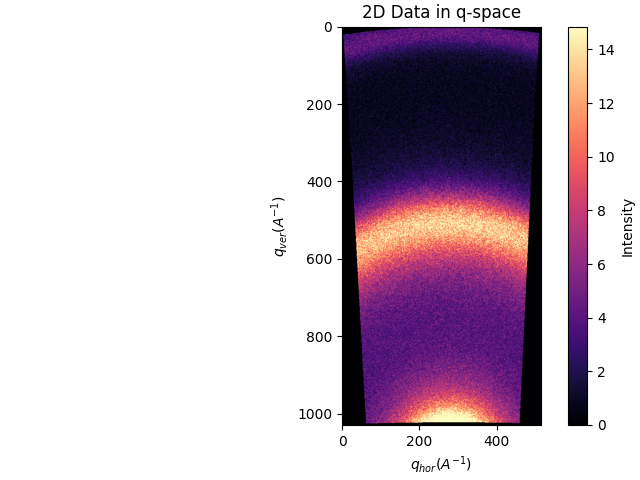

In [30]:
process_q_space(path_list[0], display=True)

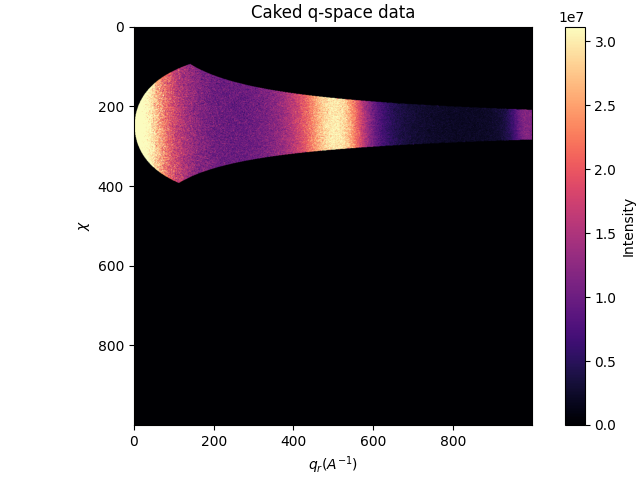

In [31]:
process_caking(path_list[0], display=True)

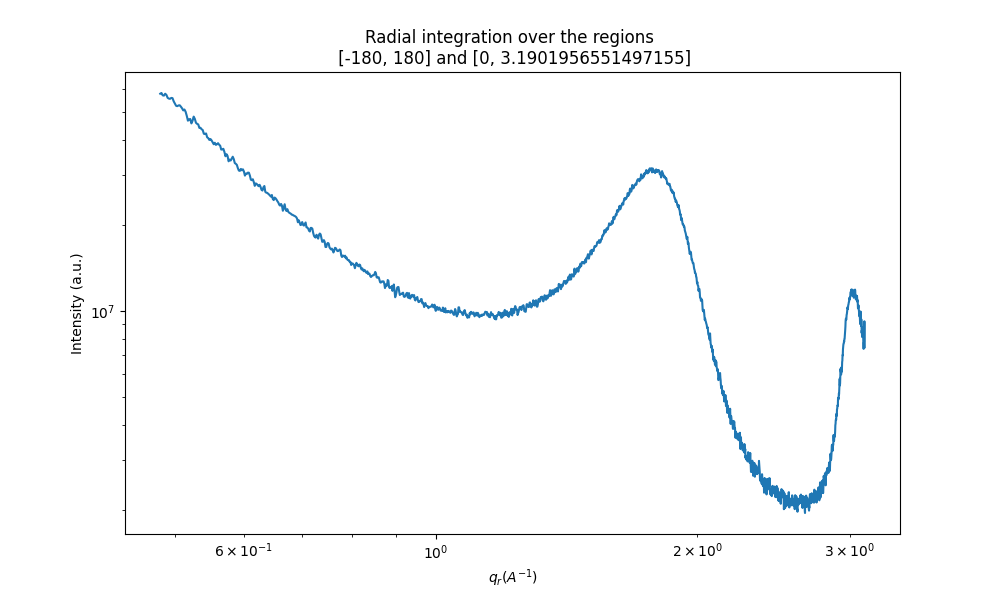

In [32]:
process_radial_average(path_list[0], display=True)

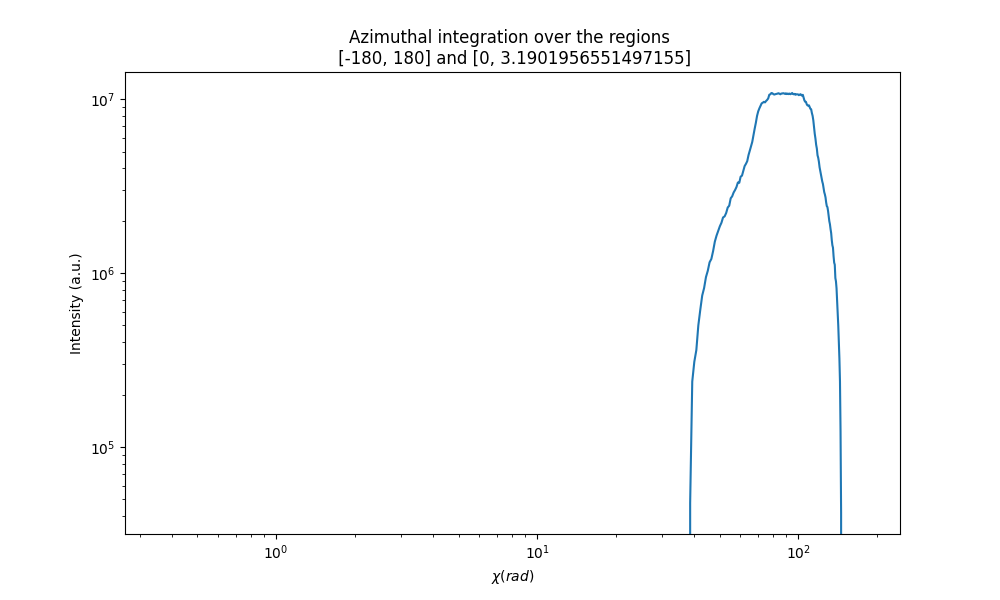

In [33]:
process_azimuthal_average(path_list[0], display=True)

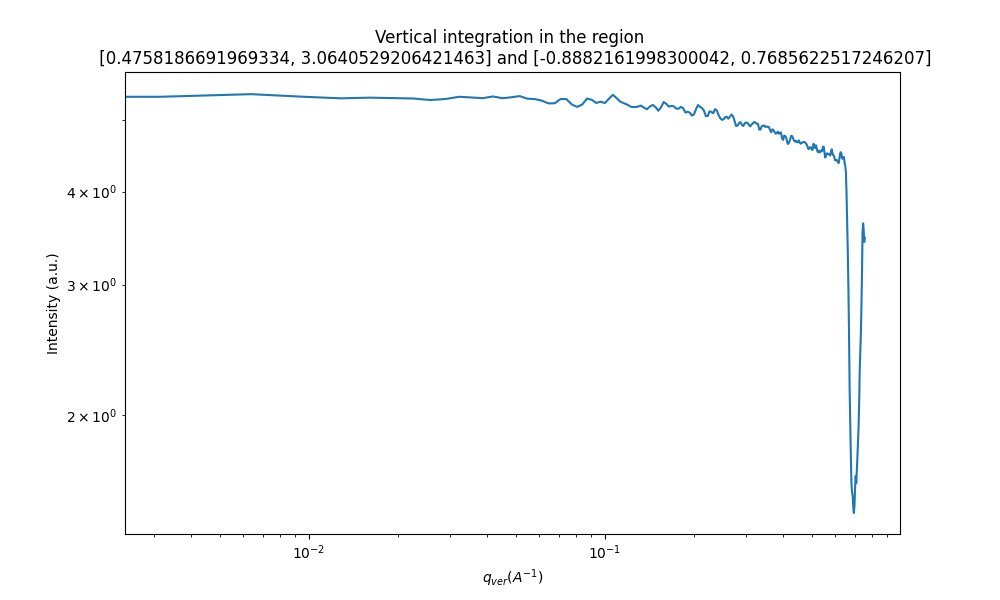

In [34]:
process_horizontal_integration(path_list[0], display=True)

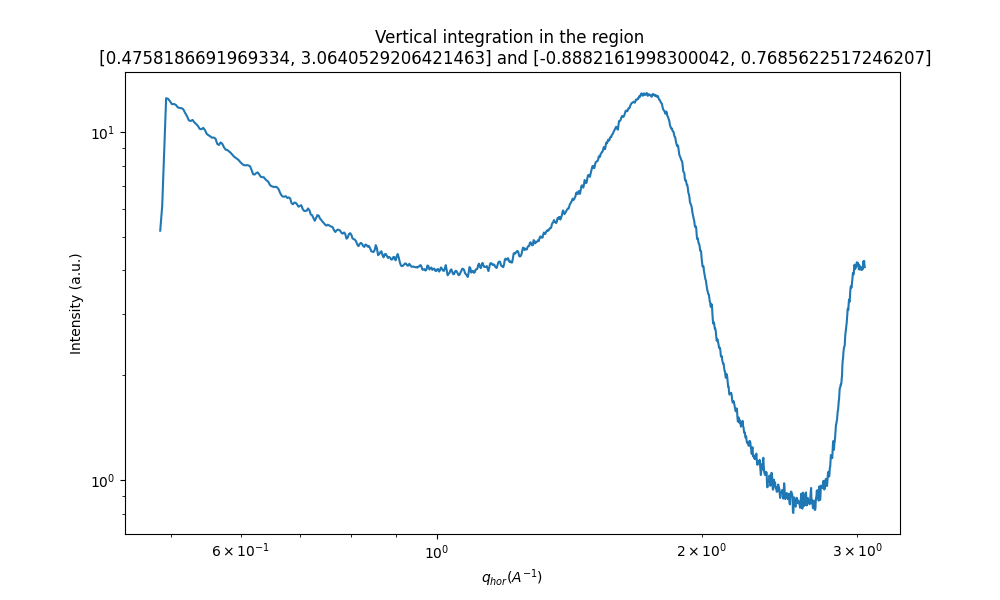

In [35]:
process_vertical_integration(path_list[0], display=True)